In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#Upload the Faulty Training 
df = pd.read_csv('/Users/mansimran/TEP_Faulty_Training.csv', on_bad_lines='skip')

#Upload the FaultFree Training
df2 = pd.read_csv('/Users/mansimran/TEP_FaultFree_Training.csv', on_bad_lines='skip')

In [3]:
#Upload the Faulty Testing 
df_test = pd.read_csv('/Users/mansimran/TEP_Faulty_Testing.csv', on_bad_lines='skip')

#Upload the FaultFree Training
df2_test = pd.read_csv('/Users/mansimran/TEP_FaultFree_Testing.csv', on_bad_lines='skip')

In [4]:
#Sub-sample
df = df.loc[(df['simulationRun']<51),:]
#df2 = df2.loc[(df2['simulationRun']<51),:]

df_test = df_test.loc[(df_test['simulationRun']<41),:]
df2_test = df2_test.loc[(df2_test['simulationRun']<201),:]

In [5]:
#Combine Test data
combined_df_test = pd.concat([df_test, df2_test], ignore_index=True)

In [6]:
#Combine Training data
combined_df = pd.concat([df, df2], ignore_index=True)

In [9]:
#These are the features that I remove based on EDA - EDA file seperate
features_to_plot = ['xmeas_2','xmeas_5', 'xmeas_12', 'xmeas_14', 'xmeas_15', 'xmeas_17', 'xmeas_37','xmv_7', 'xmv_8']

def featureengg(combined_df, features_to_plot):
    import pandas as pd
    from collections import defaultdict
    import numpy as np

    # Assuming combined_df, features_to_plot are defined earlier
    clean_df = combined_df.drop(columns=features_to_plot).copy()

    window_size = 20  #Window size
    j = [2, 4, 6, 8]  # Lag intervals

    new_columns = defaultdict(list)

    # Loop through faults and runs
    for fault in clean_df['faultNumber'].unique():
        for run in clean_df[clean_df['faultNumber'] == fault]['simulationRun'].unique():
            mask = (clean_df['faultNumber'] == fault) & (clean_df['simulationRun'] == run)

            for feature in clean_df.columns.difference(['faultNumber', 'simulationRun', 'sample']):
                frequency_feat = [np.nan] * len(clean_df.loc[mask, feature])
                feature_ma = f'{feature}_MA'
                feature_std = f'{feature}_STD'

                # Calculate moving average and standard deviation
                ma = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).mean()
                std = clean_df.loc[mask, feature].rolling(window=window_size, min_periods=1).std()


                new_columns[feature_ma].extend(ma)
                new_columns[feature_std].extend(std)

                # Calculate and store lagged features
                for i in j:
                    lag_name = f'{feature}_lag{i}'
                    lag = clean_df.loc[mask, feature].shift(i)
                    new_columns[lag_name].extend(lag)

                #Calculate the FFT
                feature_f = f'{feature}_frequency'
                for i in range(len(clean_df.loc[mask, feature])):
                    if i < window_size:
                        frequency_feat[i] = np.nan
                    else:
                        frequency_feat[i] = np.abs(np.fft.fft(clean_df.loc[mask, feature][i-window_size:i])[1:]).max()

                new_columns[feature_f].extend(frequency_feat)



    for key in new_columns:
        new_columns[key] = pd.Series(new_columns[key], index=clean_df.index)

    new_columns_df = pd.DataFrame(new_columns)
    clean_df = pd.concat([clean_df, new_columns_df], axis=1)
    return clean_df

In [ ]:
#Feature engineering of Training Data
clean_df = featureengg(combined_df, features_to_plot)

#For Binary classification
clean_df_cleaned = clean_df.dropna(axis=0)
clean_df_cleaned['faultNumber'] = (clean_df_cleaned['faultNumber'] > 0).astype(int)
comb_x_df = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df = clean_df_cleaned['faultNumber']

#For Multi Classification
clean_df_cleaned = clean_df.dropna(axis=0)
comb_x_df2 = clean_df_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df2 = clean_df_cleaned['faultNumber']



In [ ]:
#Feature engineering of Testing Data
clean_df_test = featureengg(combined_df_test, features_to_plot)

#For Binary classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
clean_df_test_cleaned['faultNumber'] = (clean_df_test_cleaned['faultNumber'] > 0).astype(int)
comb_x_df_test = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df_test = clean_df_test_cleaned['faultNumber']

#For Multi classification
clean_df_test_cleaned = clean_df_test.dropna(axis=0)
comb_x_df_test2 = clean_df_test_cleaned.drop(columns=['faultNumber','simulationRun','sample'])
comb_y_df_test2 = clean_df_test_cleaned['faultNumber']


In [ ]:
#For Binary classification

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer


A1 = Pipeline([('A_',StandardScaler(with_mean=False))])
clf = RandomForestClassifier(n_estimators=200, max_depth=40)



full_pipeline_Kbest = Pipeline([('initial_transform', A1), ('RFR', clf)])
X_new=full_pipeline_Kbest.fit(comb_x_df, comb_y_df)



In [ ]:
#Results for binary model
predictions = full_pipeline_Kbest.predict(comb_x_df_test)
results_df = pd.DataFrame({
    'Actual': comb_y_df_test,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})


results_df['sample'] = clean_df_test_cleaned['sample']
results_df['simulationRun'] = clean_df_test_cleaned['simulationRun']

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

accuracy = accuracy_score(results_df.loc[results_df['sample']>160,'Actual'],
                               results_df.loc[results_df['sample']>160,'Predicted'])
print(f"Accuracy: {accuracy}")

plt.show()
anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

anotherone = results_df.loc[results_df['sample']>160].groupby(['Actual']).agg({'Predicted':'count', 'Correct':'sum'})
anotherone['accuracy'] = anotherone['Correct']/anotherone['Predicted']

print(results_df)

In [ ]:

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
conf_matrix =confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
precision, recall, f1, _ = precision_recall_fscore_support(results_df['Actual'], results_df['Predicted'], average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nF1-Score: {f1}")

# Accuracy
accuracy = accuracy_score(results_df['Actual'], results_df['Predicted'])
print(f"Accuracy: {accuracy}")

In [ ]:
#Predict Training Data, and use this for training of Multi-classification
New_predict=full_pipeline_Kbest.predict(comb_x_df)
clean_df_cleaned['Result'] = New_predict

New_predict_test=full_pipeline_Kbest.predict(comb_x_df_test)
clean_df_test_cleaned['Result'] = New_predict_test

smaller = clean_df_cleaned.loc[clean_df_cleaned['Result']==1]
smaller.drop(columns='Result',inplace=True)
my_classifierx = smaller.drop(columns=['faultNumber','simulationRun','sample'])
my_classifiery = smaller['faultNumber']

smaller_test = clean_df_test_cleaned.loc[clean_df_test_cleaned['Result']==1]
smaller_test.drop(columns='Result',inplace=True)
smaller_test.loc[smaller_test['sample'] < 161, 'faultNumber'] = 0
my_testx = smaller_test.drop(columns=['faultNumber','simulationRun','sample'])
my_testy = smaller_test['faultNumber']

In [ ]:
#For Multiclassification
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer


A1 = Pipeline([('A_',StandardScaler(with_mean=False))])

clf = RandomForestClassifier(n_estimators=200, max_depth=40)

full_pipeline_Kbest2 = Pipeline([('initial_transform', A1), ('RFR', clf)])


X_new2=full_pipeline_Kbest2.fit(my_classifierx, my_classifiery)


In [50]:
#Results for Multi classification

predictions = 
results_df = pd.DataFrame({
    'Actual': comb_y_df_test2,
    'Predicted': predictions,
    'Correct': comb_y_df_test == predictions,
})
results_df['sample'] = clean_df_test_cleaned['sample']
results_df['Predicted'].loc[results_df['Predicted']==1]=predictions2

results_df.loc[results_df['sample'] < 161, 'Actual'] = 0
results_df['Correct'] = results_df['Actual'] == results_df['Predicted']

from sklearn.metrics import classification_report

# Assuming y_true contains the true labels and y_pred contains your model predictions
print(classification_report(results_df['Actual'], results_df['Predicted']))


/var/folders/k8/mhcdfsy54qv7hl6yxz02blx80000gn/T/ipykernel_1198/3789959338.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df['Predicted'].loc[results_df['Predicted']==1]=predictions2


              precision    recall  f1-score   support

           0       0.90      0.98      0.94    300000
           1       0.98      0.98      0.98     32000
           2       1.00      0.98      0.99     32000
           3       0.20      0.12      0.15     32000
           4       0.91      0.93      0.92     32000
           5       0.85      0.70      0.77     32000
           6       1.00      1.00      1.00     32000
           7       1.00      1.00      1.00     32000
           8       0.83      0.79      0.81     32000
           9       0.21      0.26      0.23     32000
          10       0.65      0.57      0.61     32000
          11       0.76      0.69      0.72     32000
          12       0.72      0.71      0.72     32000
          13       0.89      0.78      0.83     32000
          14       0.92      0.93      0.93     32000
          15       0.18      0.29      0.23     32000
          16       0.65      0.42      0.51     32000
          17       0.86    

<Axes: >

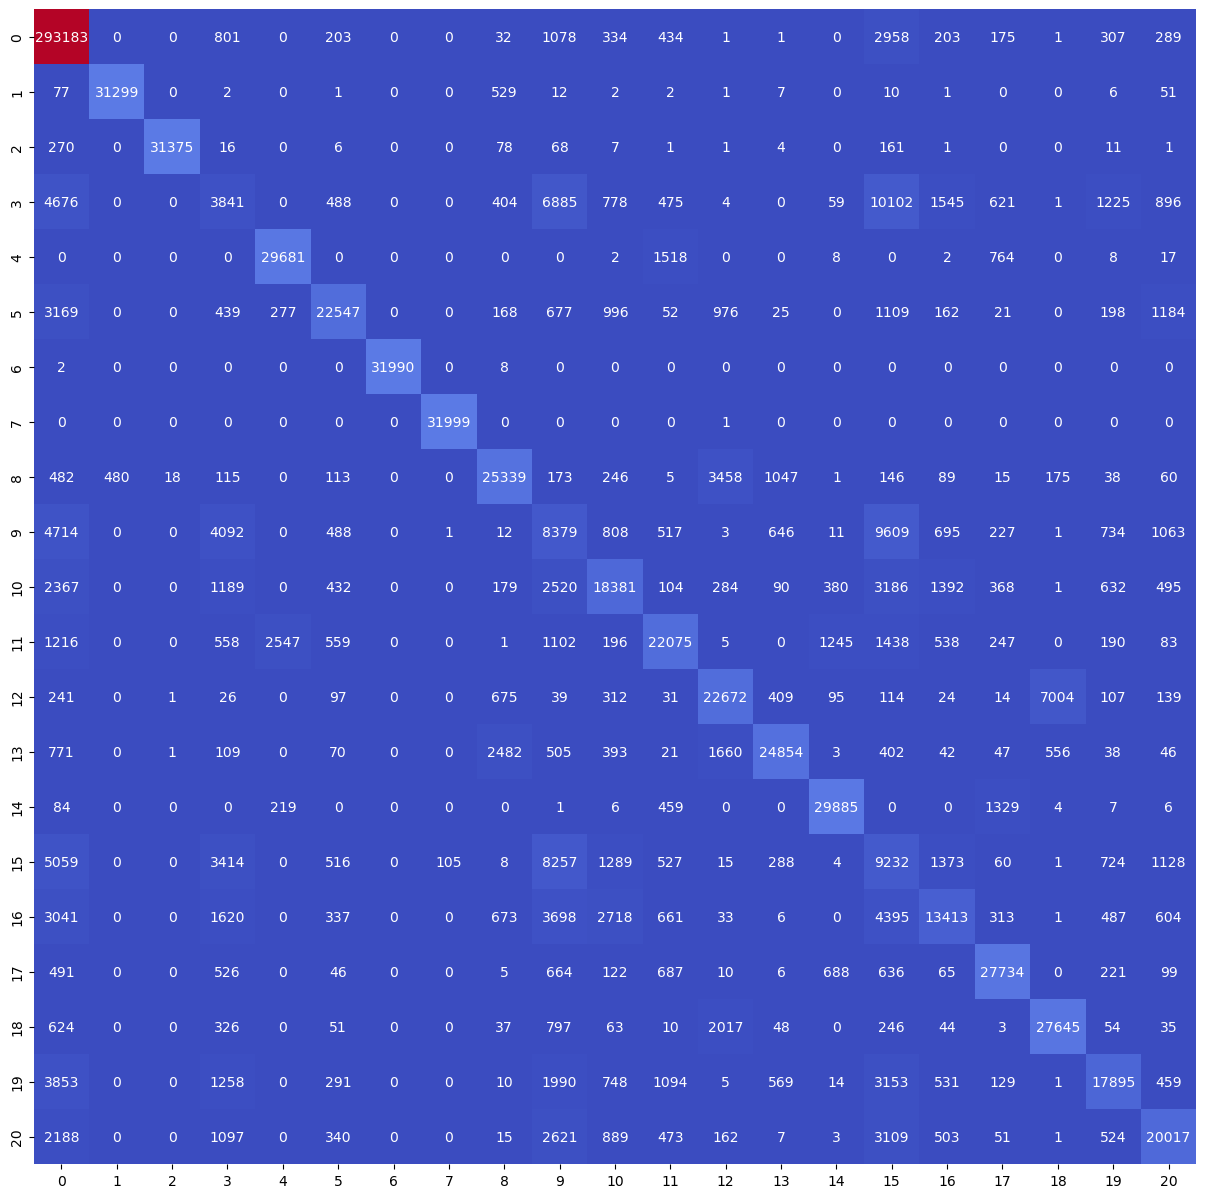

In [53]:
#Results for multiclassification

plt.figure(figsize=(15, 15))
conf_matrix = confusion_matrix(results_df['Actual'],
                               results_df['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='coolwarm', cbar=False)

        0_ratio  1_ratio  2_ratio  3_ratio  4_ratio  5_ratio  6_ratio  \
sample                                                                  
21        0.958      NaN      NaN      NaN      NaN      NaN      NaN   
22        0.969      NaN      NaN      NaN      NaN      NaN      NaN   
23        0.979      NaN      NaN      NaN      NaN      NaN      NaN   
24        0.979      NaN      NaN      NaN      NaN      NaN      NaN   
25        0.979      NaN      NaN      NaN      NaN      NaN      NaN   
...         ...      ...      ...      ...      ...      ...      ...   
956       1.000      1.0      1.0    0.025    0.850    0.600      1.0   
957       1.000      1.0      1.0    0.000    0.875    0.550      1.0   
958       1.000      1.0      1.0    0.125    0.875    0.625      1.0   
959       1.000      1.0      1.0    0.075    0.875    0.675      1.0   
960       1.000      1.0      1.0    0.075    0.850    0.625      1.0   

        7_ratio  8_ratio  9_ratio  ...  11_ratio  

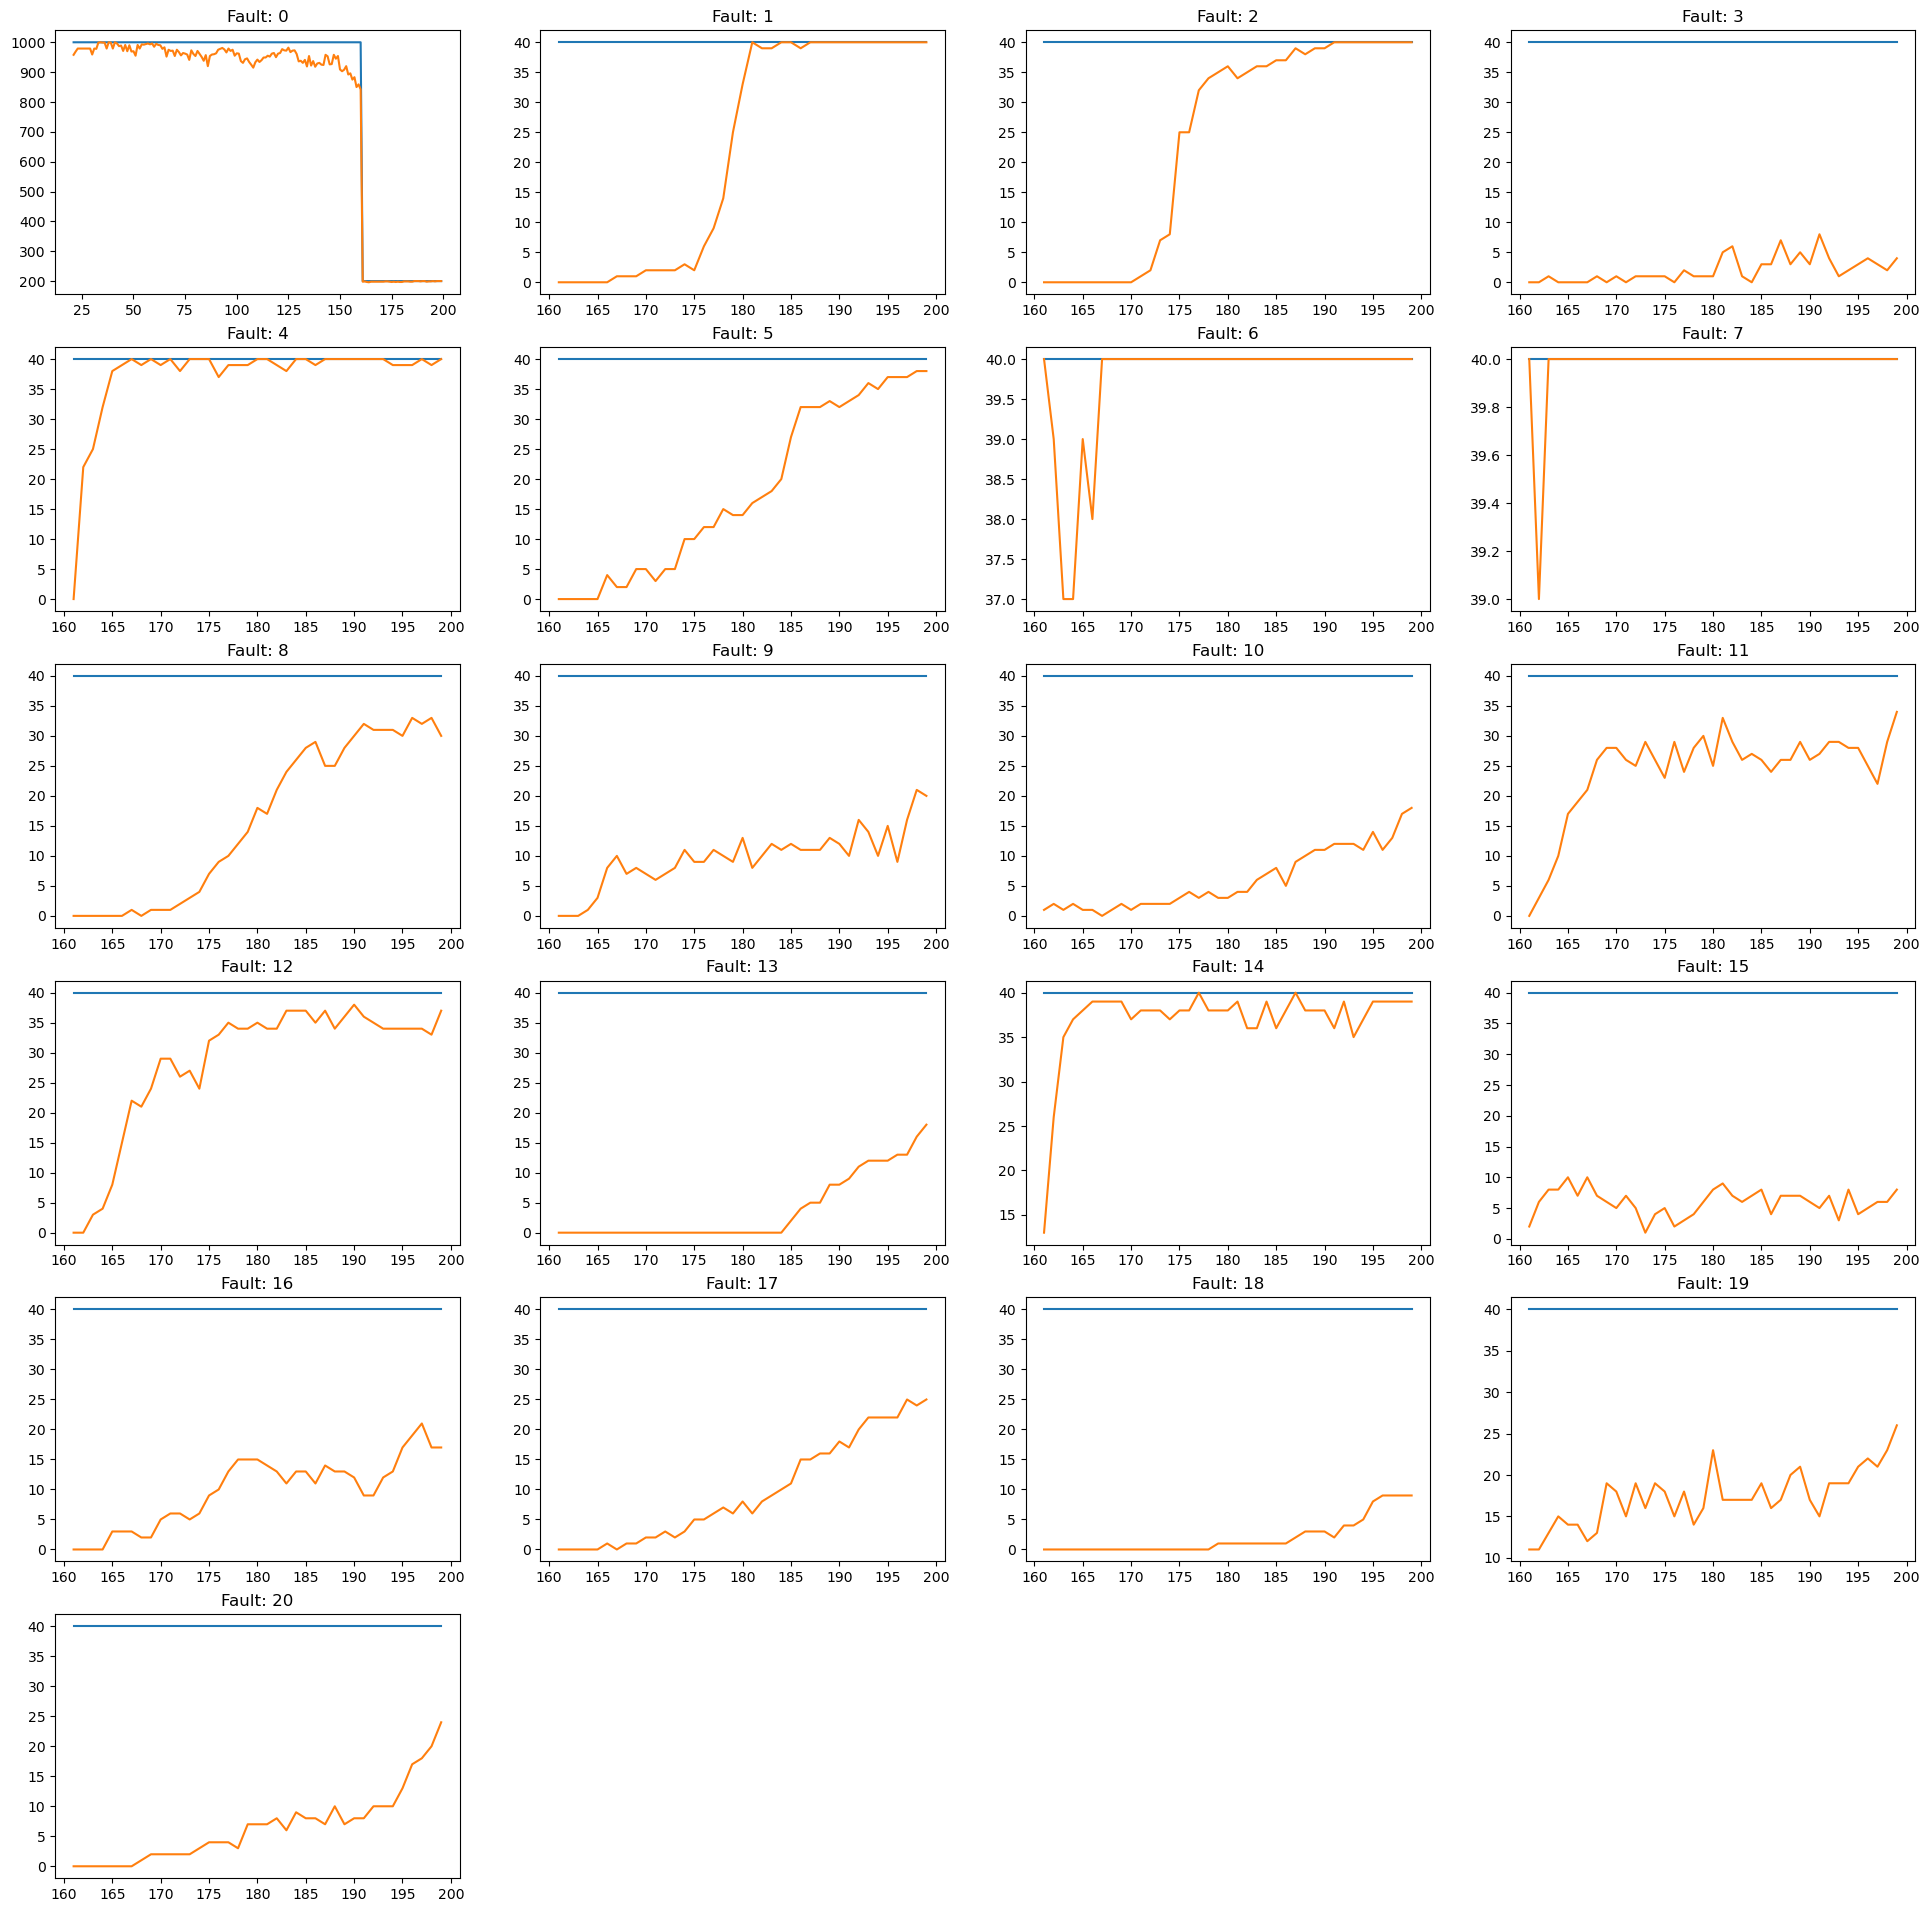

In [59]:
#Results for multi classification
results_ratio_dict = {}
plt.figure(figsize=(24, 24))
for fault in results_df['Actual'].unique():
    plt.subplot(6,4,fault+1)
    one_one = results_df.loc[(results_df['Actual']==fault) & (results_df['sample']<200)].groupby(['sample']).count()
    plt.plot(one_one['Actual'])
    tne_one = results_df.loc[(results_df['Actual']==fault) & (results_df['sample']<200)].groupby(['sample']).sum()
    plt.plot(tne_one['Correct'])
    plt.title(f'Fault: {fault}')
    sums = results_df.loc[results_df['Actual'] == fault].groupby('sample')['Correct'].sum()
    
    # Count the occurrences of each 'Sample' within the current fault
    counts = results_df.loc[results_df['Actual'] == fault].groupby('sample').size()
    
    # Calculate the ratio (sum/count) and store it in the dictionary
    ratio = sums / counts
    results_ratio_dict[f'{fault}_ratio'] = ratio

# Convert the dictionary into a DataFrame
results_ratio_df = pd.DataFrame(results_ratio_dict)

print(results_ratio_df)

Precision: 0.9602015365294543
Recall: 0.957522340425532
F1-Score: 0.9579833881033678
Accuracy: 0.957522340425532


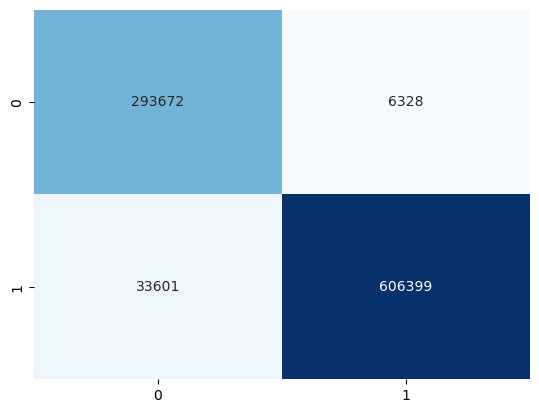